In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline, interp1d
from scipy import optimize
import matplotlib.pyplot as plt
import calendar
from matplotlib import collections as matcoll
from math import pi
from pylab import imshow
from scipy import fftpack, signal
%matplotlib inline
%config InlineBackend.figure_format='retina'

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load(r'data\max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



Text(0, 0.5, 'Cumulative probability')

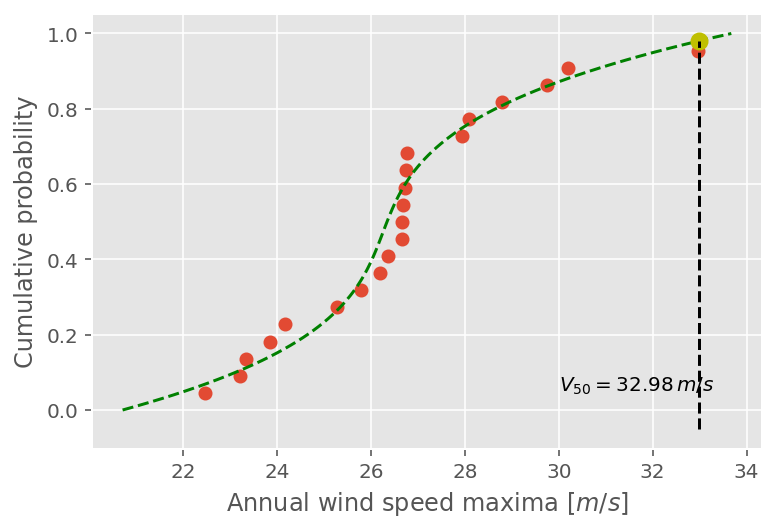

In [73]:
#load data
max_speeds = np.load(r'data\max-speeds.npy')
years_nb = max_speeds.shape[0]
N = 21

#declare x,y variables
cprob = np.array([i/(N+1) for i in range(1,22)])
sorted_max_speeds = np.sort(max_speeds)

speed_spline = UnivariateSpline(cprob, sorted_max_speeds)
nprob = np.linspace(0, 1, 100)
fitted_max_speeds = speed_spline(nprob)

fifty_prob = 1. - 0.02
fifty_wind = speed_spline(fifty_prob)

#plot figure
plt.figure()
plt.plot(sorted_max_speeds, cprob, 'o')
plt.plot(fitted_max_speeds, nprob, 'g--')
plt.plot([fifty_wind], [fifty_prob], 'o', ms=8., mfc='y', mec='y')
plt.text(30, 0.05, '$V_{50} = %.2f \, m/s$' % fifty_wind)
plt.plot([fifty_wind, fifty_wind], [plt.axis()[2], fifty_prob], 'k--')
plt.xlabel('Annual wind speed maxima [$m/s$]')
plt.ylabel('Cumulative probability')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

For the Min temperature the output parameters are: [  0.07393648  -2.05806462  17.67305264 -46.00846607 -28.52020202]
For the Max temperature the output parameters are: [  0.03095862  -0.82473776   6.62376166 -14.98208042  26.86363636]
We see that using $x^{4}$ polynomial function for curve fitting is not the exact for both minTemp and MaxTemp curve fitting 

Min temp. time offset (blue vertical line): 6.666666666666666
Max temp. time offset (red vertical line): 7.0
We also see that the time offset for min and max temperatures are not same within the fit accuracy.


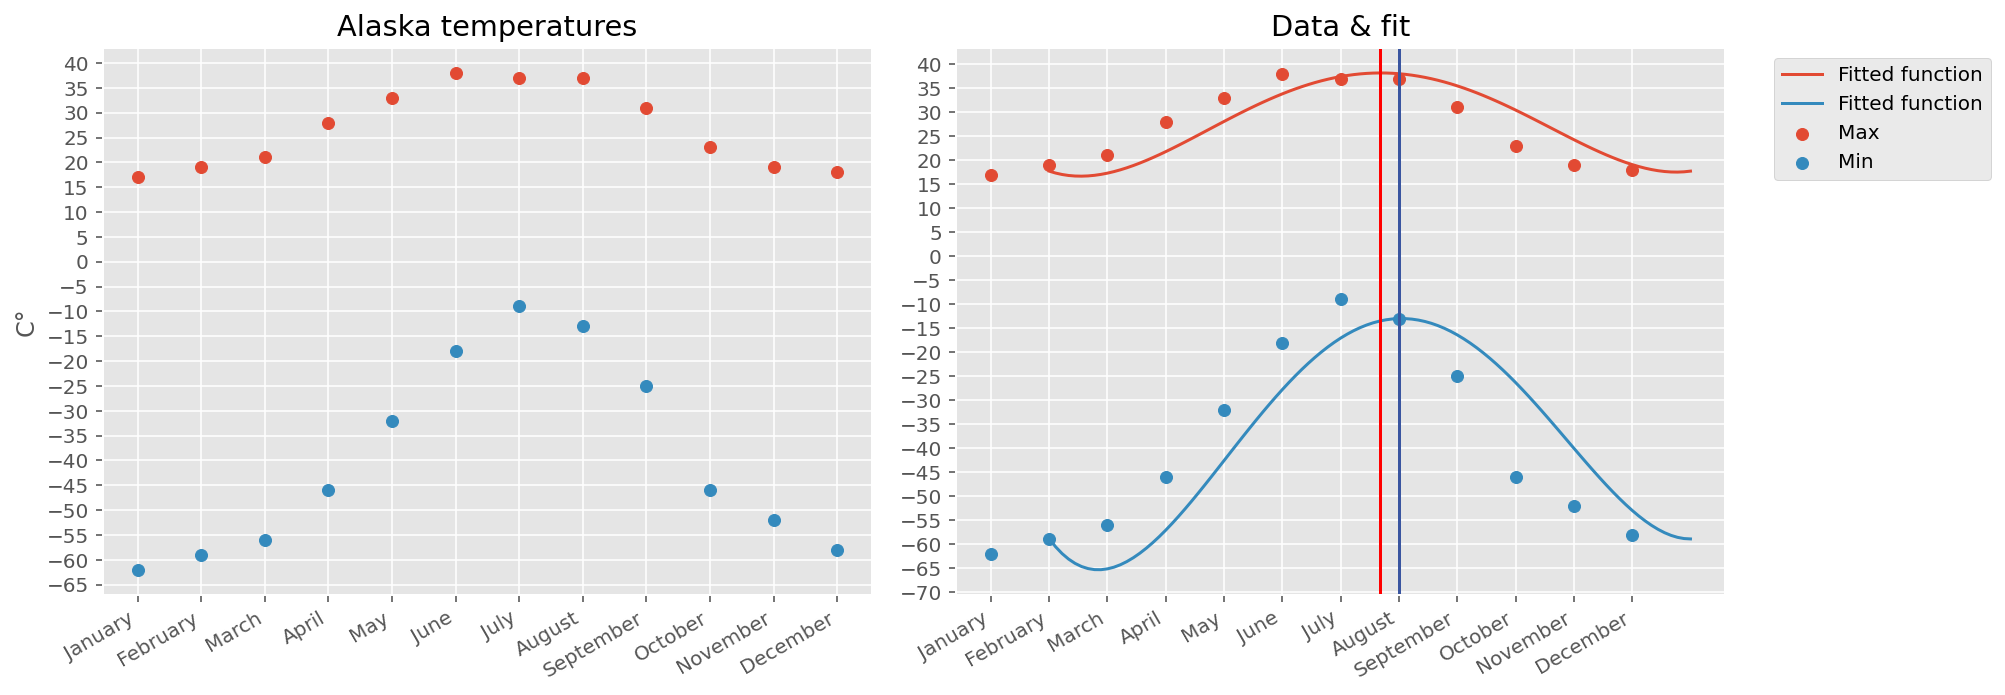

In [133]:
x = list(calendar.month_name)
del(x[0])
max = [17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18]
min = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]
y = np.array([[max[i],min[i]] for i in range(0,12)])

#Plot these temperature extremes.
plt.style.use('ggplot')

fig, (ax, ax1) = plt.subplots(1,2,figsize=(12,5))
fig.tight_layout()
fig.autofmt_xdate()

ax.set_ylabel('C°')
line1,line2 = y[0:,0], y[0:,1]
ax.set_title('Alaska temperatures')
ax.set_yticks(np.arange(-70,45,5), minor=False)
ax.scatter(x,line1,label='Max')
ax.scatter(x,line2,label='Min')

#Define a function that can describe min and max temperatures.
#Fit this function to the data with scipy.optimize.curve_fit().
x1 = np.linspace(1, 12, 100)
def f(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

params, params_covariance = optimize.curve_fit(f, x_num, line2,)
params1, params_covariance1 = optimize.curve_fit(f, x_num, line1)
print('For the Min temperature the output parameters are:',params)
print('For the Max temperature the output parameters are:',params1)

#Plot the result. Is the fit reasonable? If not, why?
ax1.scatter(x,line1,label='Max')
ax1.scatter(x,line2,label='Min')
ax1.set_yticks(np.arange(-70,45,5), minor=False)
ax1.plot(x1, f(x1, params1[0], params1[1], params1[2], params1[3], params1[4]),
         label='Fitted function')
ax1.plot(x1, f(x1, params[0], params[1], params[2], params[3], params[4]),
         label='Fitted function')
ax1.set_title('Data & fit')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

max1 = x1[np.argmax(f(x1, params1[0], params1[1], params1[2], params1[3], params1[4]))]
min1 = x1[np.argmax(f(x1, params[0], params[1], params[2], params[3], params[4]))]
ax1.axvline(min1,color="#3955a0")
ax1.axvline(max1,color="r")
#Is the time offset for min and max temperatures the same within the fit accuracy?
print("We see that using $x^{4}$ polynomial function for curve fitting is not the exact for both minTemp and MaxTemp curve fitting ")
print('\nMin temp. time offset (blue vertical line):',max1)
print('Max temp. time offset (red vertical line):',min1)
print("We also see that the time offset for min and max temperatures are not same within the fit accuracy.")

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


Optimization terminated successfully.
         Current function value: -1.031628
         Iterations: 13
         Function evaluations: 54
         Gradient evaluations: 18
The minima of the f(x,y) function is: 0.09 -0.71 
f(x_{min},y_{min}): -1.03
For an initial value of (0,0):
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 0
         Function evaluations: 3
         Gradient evaluations: 1


(0, 0)

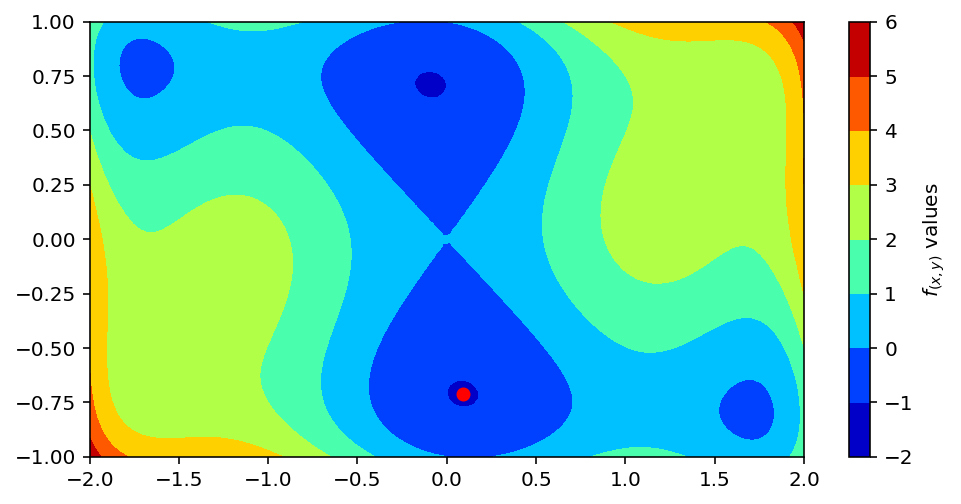

In [27]:
def f(x,y):
    return ((4 -2.1*x*x + ((x**4)/3))*x**2) + x*y + (4*y**2 - 4)*y**2

x = np.linspace(-2,2,100)
y = np.linspace(-1,1,100)
X,Y = np.meshgrid(x,y) #X and Y meshgrid of shape(100 x 100)
Z = f(X,Y)

def fmin(x):
    return (4 - 2.1*x[0]**2 + x[0]**4/3)*x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2

#Finding Minima
x0 = [1,1]
ret = optimize.fmin_bfgs(fmin,x0)

#plotting a 3d graph
fig, ax2 = plt.subplots(figsize=(8, 4))
contourmap = ax2.contourf(x,y,Z,cmap='jet')
fig.colorbar(contourmap,label='$f_{(x,y)}$ values')
ax2.plot(ret[0], ret[1],'ro')
minima = f(ret[0],ret[1])
print('The minima of the f(x,y) function is: %.2f %.2f ' % (ret[0], ret[1]))
print('f(x_{min},y_{min}): %.2f'%(minima))

#What happens for an initial guess of  (𝑥,𝑦)=(0,0)  ?
print('For an initial value of (0,0):')
x0 = [0,0]
ret = optimize.fmin_bfgs(fmin,x0)
ret[0],ret[1]

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

<ipython-input-25-51668294e369>:21: RuntimeWarning: divide by zero encountered in true_divide
  periods = 1 / frequencies


We see that there is a period of 10-11 years where the power becomes maximum and then finally comes down which is correct in prediction according to the plot of populations versus years. 
We also know in general as omega and time are inversely proportional so does the population and power(abs(fft_population))


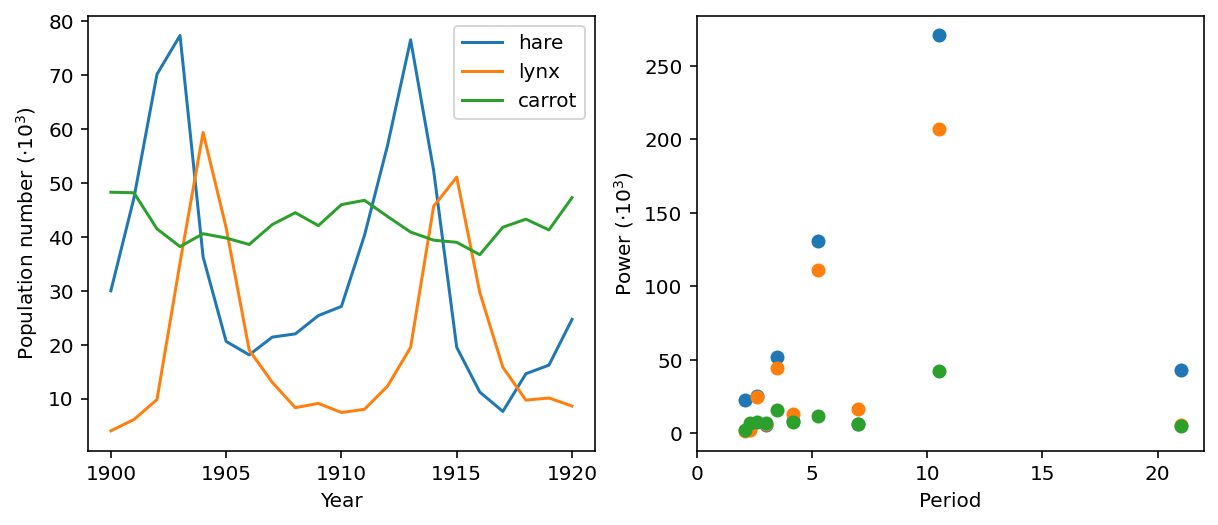

In [25]:
# Loading the data of populations
data = np.loadtxt(r'data\populations.txt')
years = data[:, 0]
populations = data[:, 1:]

# Creating subplots side by side
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# plotting population vs years 
ax1.plot(years, populations * 10**-3)
ax1.set_xlabel('Year')
ax1.set_ylabel('Population number ($\cdot10^3$)')
ax1.legend(['hare', 'lynx', 'carrot'], loc=1)


ft_populations = fftpack.fft(populations, axis=0)#complex numbers
n = populations.shape[0] 

time_step = years[1] - years[0] #Sample spacing (inverse of the sampling rate). 
frequencies = fftpack.fftfreq(n,time_step) #Array of length n containing the sample frequencies.
periods = 1 / frequencies

ax2.plot(periods, abs(ft_populations) * 1e-3, 'o') #abs(fft_signal) takes the absolute value of fft_signal since it is a complex dtype.
ax2.set_xlim(0, 22)
ax2.set_xlabel('Period')
ax2.set_ylabel('Power ($\cdot10^3$)')

print("We see that there is a period of 10-11 years where the power becomes maximum and then finally comes down which is correct in prediction according to the plot of populations versus years. ")
print("We also know in general as omega and time are inversely proportional so does the population and power(abs(fft_population))")

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

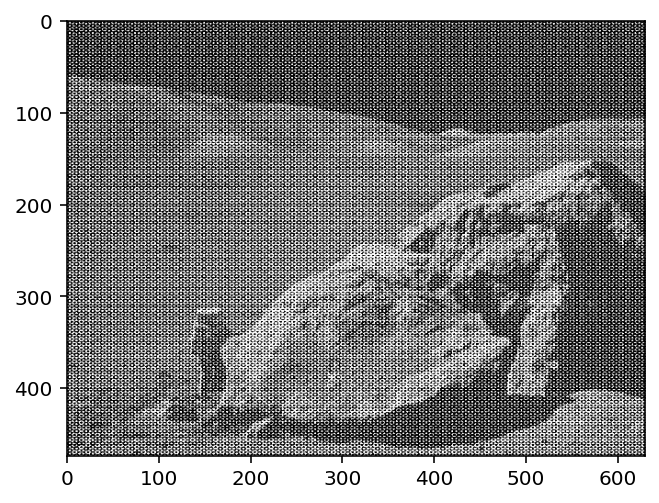

In [2]:
#Load and visualizing Image
image = r'data\moonlanding.png'
x = plt.imread(image, format=None).astype(float)
plt.imshow(x,plt.cm.gray)

(474, 630)
It is difficult to visualize the color of the levels because of their difference, it is simpler to modify the colorbar scale


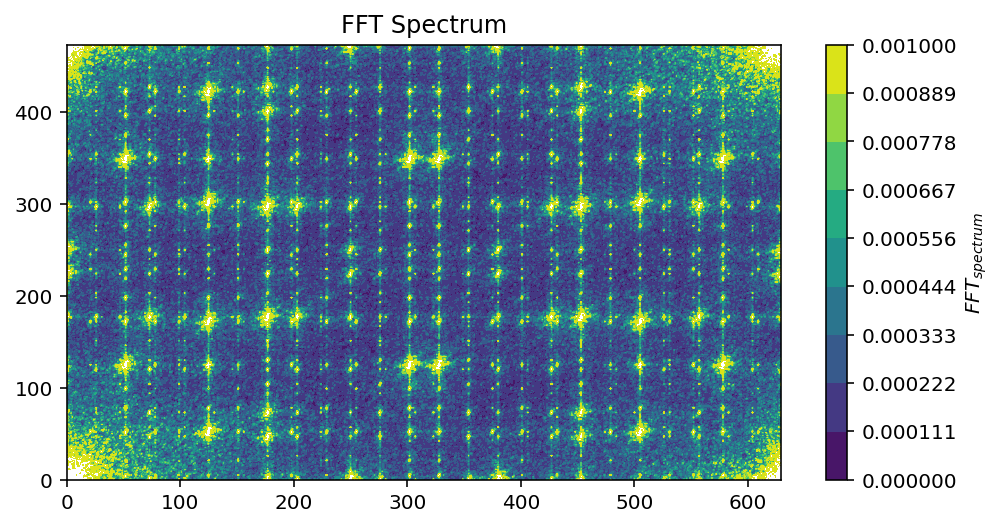

In [62]:
#Generate Spectrum
spectrum = fftpack.fft2(x, shape=None, axes=(-2, -1), overwrite_x=False)
ftt_spec = np.array(np.abs(spectrum))
ftt_spec2 = ftt_spec/np.linalg.norm(ftt_spec)#Normalized only to better visualize the image
print(ftt_spec.shape)
#Plot Image
print('It is difficult to visualize the color of the levels because of their difference, it is simpler to modify the colorbar scale')
x1 = np.arange(0,x.shape[1])
y = np.arange(0,x.shape[0])
X, Y = np.meshgrid(x1, y)
fig, ax = plt.subplots(figsize=(8, 4))
countourmap = ax.contourf(X, Y, ftt_spec2,levels= np.linspace(0,0.001,10))
fig.colorbar(countourmap,label='$FFT_{spectrum}$')
plt.title('FFT Spectrum')
plt.show()

Text(0.5, 1.0, 'Low Filtered Image')

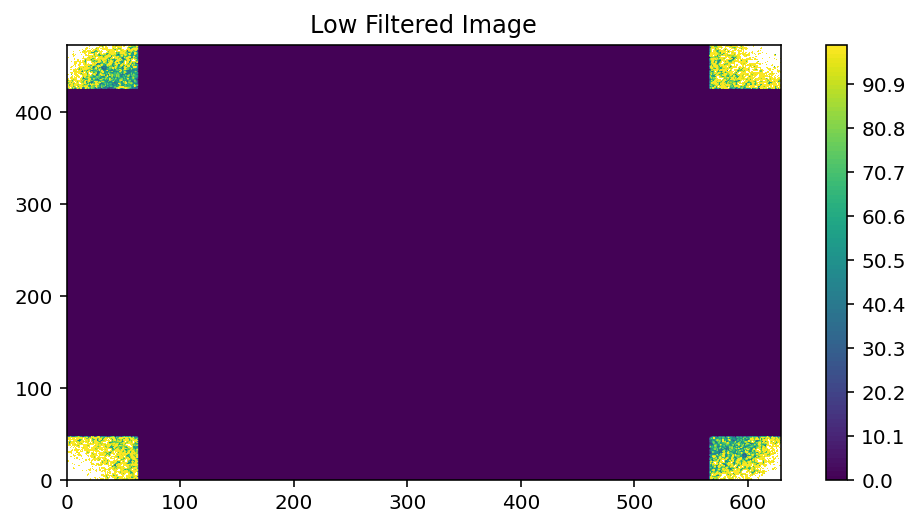

In [52]:
#Filtering hig frequencies values
ftt_image = spectrum.copy()
ftt_image2 = ftt_image.copy()
ftt_spec3 = ftt_spec.copy()

#we will cut-off the middle square part of the spectrum as seen above by making them into 0. 
#We keep only the first few rows and first few columns
#Make the middle rows and columns as 0
rows, cols = ftt_spec.shape
keep_fraction = 0.1
ftt_spec3[int(rows*keep_fraction):int(rows*(1-keep_fraction))] = 0
ftt_spec3[:, int(cols*keep_fraction):int(cols*(1-keep_fraction))] = 0

zero_indices_array = np.argwhere(ftt_spec3==0)
for i,j in zero_indices_array:
    ftt_image[i,j] = 0
    
#Plotting low frequencies spectrum
fig, ax = plt.subplots(figsize=(8, 4))
countourmap = ax.contourf(X, Y, ftt_spec3,levels= np.linspace(0,100,100))
fig.colorbar(countourmap)
plt.title('Low Filtered Image')

Text(0.5, 1.0, 'Reconstructed Image')

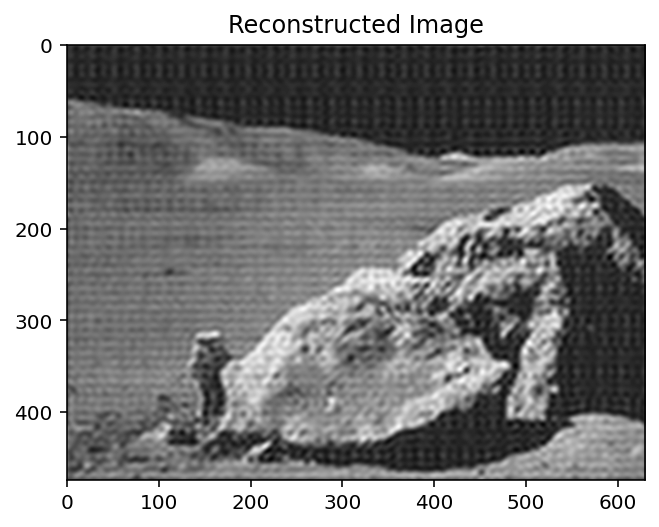

In [53]:
#Fourier Invers trasform to reconstruct image
im_new = fftpack.ifft2(ftt_image).real
plt.imshow(im_new ,cmap = 'gray')
plt.title('Reconstructed Image')

Text(0.5, 1.0, 'Reconstructed Image')

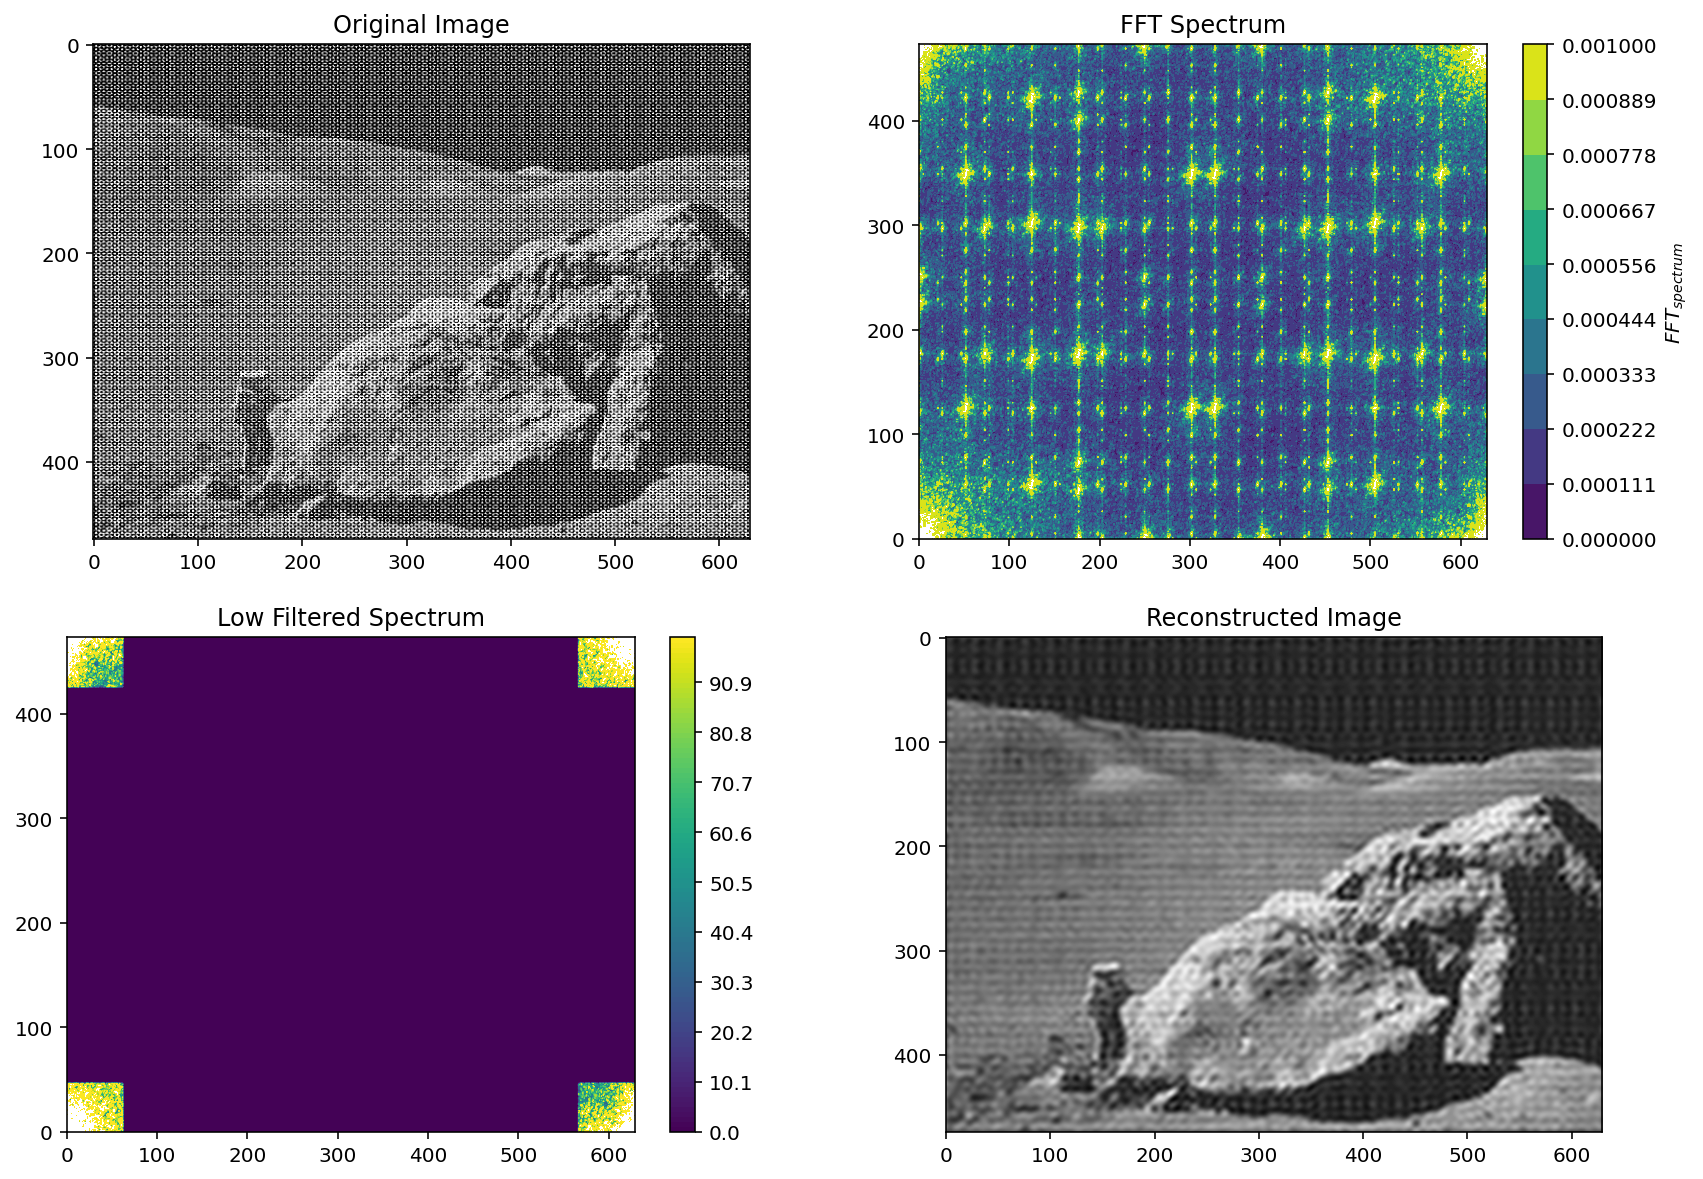

In [60]:
fig = plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
x = plt.imread(image, format=None).astype(float)
plt.imshow(x,plt.cm.gray)
plt.title('Original Image')

plt.subplot(2,2,2)
countourmap = plt.contourf(X, Y, ftt_spec2,levels= np.linspace(0,0.001,10))
fig.colorbar(countourmap,label='$FFT_{spectrum}$')
plt.title('FFT Spectrum')

plt.subplot(2,2,3)
countourmap = plt.contourf(X, Y, ftt_spec3,levels= np.linspace(0,100,100))
fig.colorbar(countourmap)
plt.title('Low Filtered Spectrum')

plt.subplot(2,2,4)
im_new = fftpack.ifft2(ftt_image).real
plt.imshow(im_new ,cmap = 'gray')
plt.title('Reconstructed Image')